In [1]:
import numpy as np
import pandas as pd
import importlib
import os
import sys
import re
import json
import matplotlib.pyplot as plt
import data_path  # 路径
import data_cleaning
from read_data import readCSV, read_xlrd, readCsvWithPandas
from datetime import datetime
from xlrd import xldate_as_tuple
from show_Kpis import getKpis
import anomaly_detection
import network
import resultForm

In [10]:
kpi_opened = {}
left_n = 10  # 保留几个结果
# 是否是执行者调用
isExecutor = {"JDBC": False, "LOCAL": False, "CSF": False,
              "FlyRemote": True, "OSB": True, "RemoteProcess": True}
# 哪一天的数据
days = ['2020_04_24','2020_04_25']
# days=['2020_04_21']

In [3]:
def find_abnormal_indicators(execption_Interval, cmdb_id,paths):
    """[该时间区间内那个指标错误]

    Args:
        execption_Interval ([type]): [时间区间]
        cmdb_id ([type]): [网源]
        paths list: [path1,path2]
    """
    kpis = {}
    abnormal_indicators = []
    # os,docker,db
    file_name = data_path.fileNames[cmdb_id.split('_')[0]]
    # file_path = os.path.join(data_path.get_data_path(),"平台指标",file_name)
    # 查看当前文件是否已经分解
    if kpi_opened.get(file_name) == None:
        for p in paths:
            kpis=getKpis([file_name],p,kpis)
        kpi_opened[file_name] = kpis
    else:
        kpis = kpi_opened[file_name]
    # 逐个指标的进行判断
    for k, v in kpis.items():
        temp = k.split(',')  # (cmdb_id,name,bomc_id,itemid)
        if cmdb_id == temp[0]:
            # todo 进行异常评估，给出得分
            score = anomaly_detection_func(execption_Interval, np.array(v))
            abnormal_indicators.append([temp[0], temp[1], temp[2], score])
    # 排序返回得分最高的三个
    return abnormal_indicators

In [4]:
def anomaly_detection_func(execption_Interval, data):
    """[异常检测算法]

    Args:
        execption_Interval ([tutle]): [时间区间(start_time,end_time)]
        data ([type]): [itemid,name,bomc_id,timestamp,valuee,cmdb_id]
    """
    data = pd.DataFrame(data)
    data.columns = ['itemid', 'name', 'bomc_id',
                    'timestamp', 'value', 'cmdb_id']
    # 根据时间戳排序
    data.sort_values("timestamp", inplace=True)
    # 得到预测值
    pred = anomaly_detection.iforest(data, ["value"])
    data['pred'] = pred
    # data.to_csv('outliers2.csv', columns=["timestamp",'value',"pred", ], header=False)
    timestamps = data['timestamp'].values.astype(np.int64)
    total, abnormal_data_total = 0, 0
    for timestamp, pred_num in zip(timestamps, pred):
        if timestamp < execption_Interval[1] and timestamp > execption_Interval[0]:
            total += 1
            abnormal_data_total += 1 if pred_num == -1 else 0

    return abnormal_data_total

In [5]:
def find_abnormal_span(trace):
    """按照图的遍历方式遍历trace中的所有span\n
    Args:
        trace ([dict]): 一条trace，格式{ startTime:str,{spanId:{},spanId:{}}}        \n
    Returns:
        [list]: 返回异常节点       \n
    """
    spans = trace['spans']
    graph = data_cleaning.generateGraph(spans)
    if graph.get('root') == None:
        return []
    abnormal_cmdb_ids = []
    Break = True
    # isError代表上溯的节点是否有异常

    def traverse(root_id, abn_ids, isError=False):
        root = spans[root_id]
        # 如果上溯有异常或本身有异常
        if isError or root['success'] == 'False':
            # 当发现是数据库出现问题时，将其他的清空，只保存数据库cmdb_id,并退出递归
            if root['db'] and root['success'] == 'False':
                abn_ids.clear()
                abn_ids.append(root["db"])
                return Break
            # 找出上一个失败的下一个成功
            if isExecutor[root['callType']] and root['callType'] != 'OSB' \
                    and root['success'] == 'True':
                abn_ids.clear()
                abn_ids.append(root["cmdb_id"])
        isError = root['success'] == 'False'
        # 如果没有子节点，直接返回
        if graph.get(root_id) == None:
            return not Break
        for span_id in graph[root_id]:
            if traverse(span_id, abn_ids, isError) == Break:
                return Break
        return not Break

    for span_id in graph.get('root'):
        abn_ids = []
        traverse(span_id, abn_ids)
        abnormal_cmdb_ids += abn_ids
    return abnormal_cmdb_ids

In [6]:
def find_abnormal_trace(execption_Interval, traces):
    """找到改异常区间内所有trace

    Args:
        execption_Interval ([type]): [时间区间]
        traces ([type]): [description]
    """
    abnormal_trace = []
    for trace in traces.values():
        startTime = int(trace['startTime'])
        if startTime > execption_Interval[0] and startTime < execption_Interval[1]:
            abnormal_trace.append(trace)
    return abnormal_trace

In [7]:
def to_standard_answer(result,fault_ids):
    answer = {}
    # 异常时间段
    for fault_id, a_result in zip(fault_ids,result):
        if len(a_result)==0 or (len(a_result)==1 and len(a_result[0])==0):
            continue
        cmdb = a_result[0][0].split("_")[0] # docker
        answer[fault_id]=[ cmdb, a_result[0][0] ] # docker_001
        if len(a_result)==1:
            answer[fault_id].extend(a_result[0][1:])
            answer[fault_id].append([None])
        else:
        # 每一个异常时间段有多个指标
            indicator_list = [an_indicator[1] for an_indicator in a_result]
            answer[fault_id].append(indicator_list)
    return answer

In [8]:
def get_abnormal_interval(days):
    business_paths = [os.path.join(data_path.get_data_path(day), "业务指标", "esb.csv") for day in days]
    # 获取业务指标数据，去掉表头,np.array
    data = None
    for p in business_paths:
        data = pd.concat([data,pd.read_csv(p)],ignore_index=True)
    data = data.values
    # 根据时间序列排序
    data = data[np.argsort(data[:, 1])]
    # todo step1 异常时间序列
    # 异常数据
    abnormal_data = anomaly_detection.find_abnormal_data(data)
    # 异常时间序列
    execption_times = abnormal_data[:, 1].astype(np.int64)
    #! 异常时间区间
    # interval_times = anomaly_detection.to_interval(execption_times)
    interval_times,fault_ids = anomaly_detection.fault_time(bias=1*60*100,file_day=days[0],type=2)
    #! 对应时间区间是否是网络故障
    is_net_error = []# anomaly_detection.is_net_error_func(interval_times,abnormal_data)
    print(len(interval_times))
    
    for i,j in zip(interval_times,is_net_error):
        print(i,j)
    # 画出找到的异常区间
    anomaly_detection.draw_abnormal_period(data, interval_times)

    return interval_times,is_net_error,fault_ids

# 开始运行

1 2
13


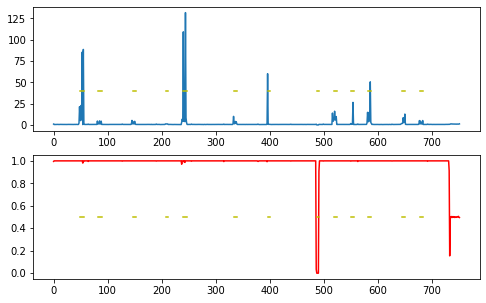

In [15]:
# 调用链指标,平台指标,数据说明
importlib.reload(network)
plat_paths = [os.path.join(data_path.get_data_path(day),"平台指标") for day in days]
interval_times,is_net_error,fault_ids = get_abnormal_interval(days)
# print(fault_ids)

In [12]:
# todo step2 获取所有trace
traces = {}
for day in days:
    prex_path = data_path.get_data_path(day)
    trace_p = os.path.join(prex_path,"调用链指标")
    data_cleaning.build_trace(trace_p,traces)

开始trace数据合并！
正在读取文件 trace_osb


trace_osb:  28%|=======================                                                            |

读取trace_osb完毕，开始生成trace


trace_osb: 100%|===================================================================================|


文件trace_osb_.csv 合并完毕,共花费 1.3158698081970215S
正在读取文件 trace_csf


trace_csf:   8%|======                                                                             |

读取trace_csf完毕，开始生成trace


trace_csf: 100%|===================================================================================|


文件trace_csf_.csv 合并完毕,共花费 3.7188501358032227S
正在读取文件 trace_fly_remote


trace_fly_remote:  26%|===================                                                         |

读取trace_fly_remote完毕，开始生成trace


trace_fly_remote: 100%|============================================================================|


文件trace_fly_remote_.csv 合并完毕,共花费 1.2608489990234375S
正在读取文件 trace_remote_process


trace_remote_process:   7%|====                                                                    |

读取trace_remote_process完毕，开始生成trace


trace_remote_process: 100%|========================================================================|


文件trace_remote_process_.csv 合并完毕,共花费 4.608765602111816S
正在读取文件 trace_local


trace_local:   1%|=                                                                                |

读取trace_local完毕，开始生成trace


trace_local: 100%|=================================================================================|


文件trace_local_.csv 合并完毕,共花费 17.78169298171997S
正在读取文件 trace_jdbc


trace_jdbc:   1%|=                                                                                 |

读取trace_jdbc完毕，开始生成trace


trace_jdbc: 100%|==================================================================================|


文件trace_jdbc_.csv 合并完毕,共花费 24.02991533279419S
Trace 合并完毕！共花费 52.71594285964966S,分别是 [1.3158698081970215, 3.7188501358032227, 1.2608489990234375, 4.608765602111816, 17.78169298171997, 24.02991533279419]
开始trace数据合并！
正在读取文件 trace_osb
读取trace_osb完毕，开始生成trace


trace_osb: 100%|===================================================================================|


文件trace_osb_.csv 合并完毕,共花费 0.8364510536193848S
正在读取文件 trace_csf


trace_csf:   7%|=====                                                                              |

读取trace_csf完毕，开始生成trace


trace_csf: 100%|===================================================================================|


文件trace_csf_.csv 合并完毕,共花费 4.6002936363220215S
正在读取文件 trace_fly_remote


trace_fly_remote:  17%|============                                                                |

读取trace_fly_remote完毕，开始生成trace


trace_fly_remote: 100%|============================================================================|


文件trace_fly_remote_.csv 合并完毕,共花费 1.2895982265472412S
正在读取文件 trace_remote_process


trace_remote_process:   9%|======                                                                  |

读取trace_remote_process完毕，开始生成trace


trace_remote_process: 100%|========================================================================|


文件trace_remote_process_.csv 合并完毕,共花费 7.21590781211853S
正在读取文件 trace_local


trace_local:   1%|=                                                                                |

读取trace_local完毕，开始生成trace


trace_local: 100%|=================================================================================|


文件trace_local_.csv 合并完毕,共花费 21.642325401306152S
正在读取文件 trace_jdbc
读取trace_jdbc完毕，开始生成trace


trace_jdbc: 100%|==================================================================================|


文件trace_jdbc_.csv 合并完毕,共花费 81.61350345611572S
Trace 合并完毕！共花费 117.19807958602905S,分别是 [0.8364510536193848, 4.6002936363220215, 1.2895982265472412, 7.21590781211853, 21.642325401306152, 81.61350345611572]


In [ ]:
abnormal_cmdb_all = []
# 结果
result = [ 0 for _ in range(len(interval_times))]
#? 遍历每一个时间端
for i in range(len(interval_times)):
    # 异常时间区间
    execption_Interval = interval_times[i]
    # 异常指标
    abnormal_indicators = []
    # todo step3 找出这段时间内的trace
    abnormal_traces = find_abnormal_trace(execption_Interval, traces)
    # 如果是网络故障
    # print(is_net_error[i])
    # is_net_error[i] = False
    if False:
        #do something
        net_error_cmdb_id = network.locate_net_error(abnormal_traces)
        abnormal_cmdb_all.append(net_error_cmdb_id)
        abnormal_indicators.append( net_error_cmdb_id )
    else :
        # abnormal_traces trace 中定位到具的体节点，即cmdb_id
        abnormal_cmdb_ids = list(set(network.locate_net_error(abnormal_traces)))
        # todo step4 找出异常数据中的异常节点
        for trace in abnormal_traces:
            abnormal_cmdb_ids += find_abnormal_span(trace)
        # 去重
        abnormal_cmdb_ids = list(set(abnormal_cmdb_ids))
        
        abnormal_cmdb_all.append(abnormal_cmdb_ids)
        # todo step5 判断网元节点中是哪个指标有异常
        for cmdb_id in abnormal_cmdb_ids:
            # ? 找到异常指标c 
            abnormal_indicators.extend(find_abnormal_indicators(
                execption_Interval, cmdb_id,plat_paths))
            print(execption_Interval, cmdb_id)
        # 对得到的异常指标进行排序
        abnormal_indicators = sorted(
            abnormal_indicators, key=lambda x: x[-1], reverse=True)[:left_n]
        if len(abnormal_indicators) !=0 and int(abnormal_indicators[0][-1])==0:
            abnormal_indicators = [abnormal_cmdb_ids]
    result[i] = np.array(abnormal_indicators)


for i in abnormal_cmdb_all:
    print(i)

计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel r

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 4 of 6 for this parallel run (total 100)...



Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...






Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[1587660420000, 1587660726000] docker_007
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...






Building estimator 1 of 6 for this parallel run (total 100)...


Buil

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...



Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel r

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 3 of 7 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...




Building estimator 5 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel r

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...




Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
计算中:   0%|                                                                                      |

[1587660420000, 1587660726000] docker_008


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished



Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
计算中:   0%|                                                                                      |

[1587662220000, 1587662526000] docker_001


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...


Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...



Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
[1587665820000, 1587666126000] docker_002


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...




Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...



Building estimator 5 of 7 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s


Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 5 of 7 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (tot

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


[1587669420000, 1587669726000] docker_001


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 7 of 7 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.





Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 7 for this parallel run (total 100)...


Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
(692, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished



Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
[1587671220000, 1587671526000] docker_002
(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Buil

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(690, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


[1587671220000, 1587671526000] docker_007
(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Buil

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...





Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished



Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(585, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.





Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(360, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...



Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...



Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...


Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...

(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.7s



Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 3 of 6 for this parallel run (total 100)...



Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 6 of 7 for this parallel run (total 100)...



Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...



Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...




Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(72, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(60, 6)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.3s


Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(24, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

(24, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.4s


Building estimator 7 of 7 for this parallel run (total 100)...
(8, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (to

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(689, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(689, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(689, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...




Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(689, 6)
Building estimator 1 of 7 for this parallel r

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(689, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished



Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(689, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.









Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
计算中:   0%|                                                                                      |

[1587671220000, 1587671526000] docker_008


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 7 for this parallel run (total 100)...


Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...




Building estimator 5 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 4 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 7 of 7 for this parallel run (total 100)...
(694, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...




Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
计算中:   0%|                                                                                      |

[1587676620000, 1587676926000] docker_008


计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (t

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...




Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 100)...


Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.




Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...




Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(696, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (tota

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...



Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...Building estimator 5 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
计算中: 100%|======================================================================================|
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (tot

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...



Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(720, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 6 for this parallel run (total 100)...

Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...

Building estimator 6 of 7 for this parallel run (total 100)...Building estimator 7 of 7 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 6 of 6 for this parallel run (total 100)...



Building estimator 7 of 7 for this parallel run (tota

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.3s


Building estimator 4 of 6 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 5 of 6 for this parallel run (total 100)...


Building estimator 6 of 6 for this parallel run (total 100)...Building estimator 4 of 7 for this parallel run (total 10

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(705, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(360, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...

Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 5 of 6 for this parallel run (

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...


Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...

Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 7 for this parallel run (total 100)...Building estimator 3 of 6 for this parallel run (total 100)...

Building estimator 3 of 6 for this parallel run (total 100)...Building estimator 4 of 6 for this parallel run (total 100)...Building estimator 3 of 7 for this parallel run (total 100)...


Building estimator 3 of 6 for this parallel run (total 100)...
Building estimator 4 of 6 for this parallel run (total 100)...
Building estimator 3 of 6 for this parallel run (total 

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 7 for this parallel run (total 100)...



Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...

Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 100)...Building estimator 2 of 6 for this parallel run (total 100)...
Building estimator 2 of 6 for this parallel run (total 1

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(715, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(705, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(705, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.4s


(360, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...
Building estimator 6 of 7 for this parallel run (total 100)...
Building estimator 7 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 2 of 7 for this parallel run (total 100)...
Building estimator 3 of 7 for this parallel run (total 100)...
Building estimator 4 of 7 for this parallel run (total 100)...
Building estimator 5 of 7 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run 

[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...

Building estimator 1 of 6 for this parallel run (total 100)...



Building estimator 1 of 6 for this parallel ru

[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


(717, 6)
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 7 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...
Building estimator 1 of 6 for this parallel run (total 100)...


Building estimator 1 of 6 for this parallel ru

In [9]:
print(len(result))
# for i in result:
#     print(i)
save_path = data_path.get_save_path()
if not os.path.exists(save_path):
    os.mkdir(save_path)
with open(os.path.join(save_path,"result_"+days[0]), 'w') as f:
    for fault_id, r in zip(fault_ids,result):
        f.write(str(fault_id)+":\n")
        for o in r:
            f.write(str(o)+'\n')
resultForm.resultForm(result,"result_"+days[0],fault_ids)

answer = to_standard_answer(result,fault_ids)
with open(os.path.join(save_path,"answer_"+days[0]+".json"), 'w') as f:
    js = json.dumps(answer, indent=2)
    f.write(js)

NameError: name 'result' is not defined